In [3]:
# 找最大最小行数
import os
import numpy as np
import matplotlib.pyplot as plt
filename_ASD = os.path.join("ABIDE_roi400", "roi400",'TD','Trinity_0051133_rois_cc400.1D')
data_ASD = np.loadtxt(filename_ASD,usecols=range(177))
data_ASD

array([[ 3068.93994141,   847.24359131,  -910.97674561, ...,
         -104.81734467,   -75.67355347, -2436.7019043 ],
       [ 3260.98486328, -1290.58166504, -1665.30578613, ...,
        -2581.53710938,  -442.6421814 , -2573.96850586],
       [ 1222.56396484, -1567.72192383,  -892.39990234, ...,
        -3185.07861328, -1089.23571777,   852.14605713],
       ...,
       [ 5683.078125  ,   595.6517334 , -2003.66967773, ...,
         -184.91148376,   745.30889893, 10523.5859375 ],
       [ 4032.72607422, -1646.67248535, -1414.5501709 , ...,
         1009.33233643,   613.65264893,  9884.17480469],
       [ 1657.26342773, -1908.16516113,  -449.0112915 , ...,
          606.9934082 ,   269.85174561,  6237.05761719]])

In [4]:
# 计算皮尔逊相关系数矩阵
corr_matrix = np.corrcoef(data_ASD.T)
corr_matrix

array([[ 1.        , -0.09418504, -0.3328005 , ..., -0.18216921,
        -0.19522262,  0.47600779],
       [-0.09418504,  1.        , -0.10852183, ..., -0.11842293,
        -0.2438911 , -0.18794037],
       [-0.3328005 , -0.10852183,  1.        , ...,  0.33160977,
         0.21542999, -0.30270545],
       ...,
       [-0.18216921, -0.11842293,  0.33160977, ...,  1.        ,
         0.01909624, -0.26051848],
       [-0.19522262, -0.2438911 ,  0.21542999, ...,  0.01909624,
         1.        , -0.26768421],
       [ 0.47600779, -0.18794037, -0.30270545, ..., -0.26051848,
        -0.26768421,  1.        ]])

/Users/yangzongxian/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yangzongxian/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yangzongxian/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yangzongxian/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


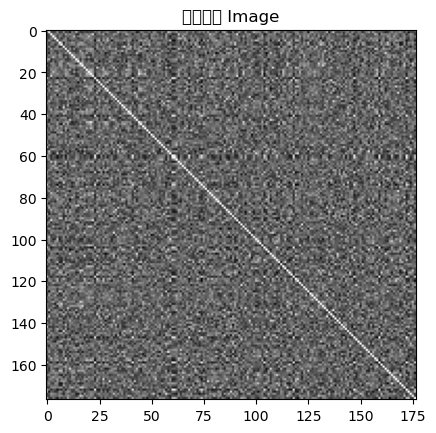

In [5]:
plt.imshow(corr_matrix, cmap='gray')
plt.title('相关系数 Image')
plt.show()

In [6]:
import numpy as np
import torch
import os
import random
from torch.utils.data import Dataset
import torch.nn.functional as F

random.seed(1)
rmb_label = {"ASD": 0, "TD": 1}      # 设置标签

class ABIDEtxtDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        ABIDE_db的Dataset
        :param data_dir: str, 数据集所在路径
        :param transform: torch.transform，数据预处理
        """
        self.label_name = {"ASD": 0, "TD": 1}
        self.data_info = self.get_txt_info(data_dir)  # data_info存储所有txt路径和标签，在DataLoader中通过index读取样本
        self.transform = transform
        print('Number of samples:', len(self.data_info))
        print('Sample info:', self.data_info[0])
        
    def __getitem__(self, index):
        path_txt, label = self.data_info[index]
        print('path_txt:',path_txt,'\nlabel:',label)
        txt_data = np.loadtxt(path_txt, usecols=range(392))

        cor = np.corrcoef(txt_data.T)
        # 将cor转换为4D的FloatTensor
        cor = torch.from_numpy(cor).float()
        
        if self.transform is not None:
            txt = self.transform(txt)   # 在这里做transform，转为tensor等等

        return cor, label

    def __len__(self):
        return len(self.data_info)

    @staticmethod
    def get_txt_info(data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            # 遍历类别
            for sub_dir in dirs:
                txt_names = os.listdir(os.path.join(root, sub_dir))
                txt_names = list(filter(lambda x: x.endswith('.1D'), txt_names))

                # 遍历txt
                for i in range(len(txt_names)):
                    txt_name = txt_names[i]
                    path_txt = os.path.join(root, sub_dir, txt_name)
                    label = rmb_label[sub_dir]
                    data_info.append((path_txt, int(label)))

        return data_info

# RNN


In [2]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 初始化隐藏层状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # 前向传播 RNN
        out, _ = self.rnn(x, h0)
        out = self.dropout(out)
        # 将输出结果展平
        out = out[:, -1, :]
        # 全连接层
        out = self.fc(out)
        return out

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, CenterCrop, Pad
from torchvision import transforms
#数据集地址
split_dir = os.path.join("ABIDE_roi400", "roi400_split")  
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")
test_dir  = os.path.join(split_dir, "test") 
print("数据集地址over")

# 定义超参数
input_size = 392*392   # 根据具体数据集修改
hidden_size = 256
num_layers = 3
num_classes = 2
batch_size = 64
learning_rate = 0.001
num_epochs = 10

#device = torch.device("mps")
print("定义超参数over")



# 实例化数据集和数据加载器
train_dataset = ABIDEtxtDataset(train_dir ,transform=None)
valid_dataset = ABIDEtxtDataset(valid_dir ,transform=None)


# 加载数据集
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
print("实例化数据集和数据加载器over")

# 实例化模型、损失函数和优化器
model = RNNModel(input_size, hidden_size, num_layers, num_classes)
#model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    # 训练阶段
    model.train()
    for i, (data, label) in enumerate(train_loader):
        # print(data.shape, label.shape)
#        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(data.float())
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # 计算训练准确率和损失
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == label).sum().item()
        train_loss += loss.item()

    # 验证阶段
    model.eval()
    with torch.no_grad():
        for i, (data, label) in enumerate(valid_loader):
            outputs = model(data.float())
            loss = criterion(outputs, label)

            # 计算验证准确率和损失
            _, predicted = torch.max(outputs.data, 1)
            valid_acc += (predicted == label).sum().item()
            valid_loss += loss.item()

    # 计算平均损失和准确率
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    train_acc /= len(train_loader.dataset)
    valid_acc /= len(valid_loader.dataset)

    # 保存损失和准确率
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    # 打印训练结果
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# 可视化训练结果
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="train acc")
plt.plot(valid_accs, label="valid acc")
plt.legend()
plt.show()

数据集地址over
定义超参数over
Number of samples: 618
Sample info: ('ABIDE_roi400/roi400_split/train/ASD/NYU_0051024_rois_cc400.1D', 0)
Number of samples: 176
Sample info: ('ABIDE_roi400/roi400_split/valid/ASD/KKI_0050798_rois_cc400.1D', 0)
实例化数据集和数据加载器over


ValueError: the number of columns changed from 392 to 177 at row 25; use `usecols` to select a subset and avoid this error

# CNN

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

split_dir = os.path.join("ABIDE_roi400", "roi400_split")  
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")
test_dir  = os.path.join(split_dir, "test") 

# 定义二分类CNN模型
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 98 * 98, 512)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 98 * 98)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# 定义超参数
input_size = (392, 392)
batch_size = 32
learning_rate = 0.001
num_epochs = 50

def collate_fn(batch):
    data = [d[0] for d in batch]
    label = [d[1] for d in batch]
    # 为数据添加一个额外的维度，以便将其转换为形状为 [batch_size, 1, height, width] 的张量
    data = [d.unsqueeze(0) for d in data]
    # 将多个数据合并为一个batch
    data = torch.stack(data, dim=0)
    label = torch.tensor(label)
    return data, label






# 实例化数据集和数据加载器
train_dataset = ABIDEtxtDataset(train_dir, transform=None)
valid_dataset = ABIDEtxtDataset(valid_dir, transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,collate_fn = collate_fn)

# 实例化模型、损失函数和优化器
model = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# 训练和验证
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    for i, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

    # 验证阶段
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for data, label in valid_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.4f}")



Number of samples: 617
Sample info: ('ABIDE_roi400/roi400_split/train/ASD/NYU_0051024_rois_cc400.1D', 0)
Number of samples: 176
Sample info: ('ABIDE_roi400/roi400_split/valid/ASD/KKI_0050798_rois_cc400.1D', 0)
path_txt: ABIDE_roi400/roi400_split/train/ASD/Stanford_0051165_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/TD/USM_0050466_rois_cc400.1D 
label: 1
path_txt: ABIDE_roi400/roi400_split/train/ASD/UM_1_0050282_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/TD/Caltech_0051490_rois_cc400.1D 
label: 1
path_txt: ABIDE_roi400/roi400_split/train/TD/Olin_0050105_rois_cc400.1D 
label: 1
path_txt: ABIDE_roi400/roi400_split/train/ASD/UM_1_0050295_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/NYU_0050994_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/Stanford_0051174_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/MaxMun_a_0051363_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_spl

/Users/yangzongxian/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yangzongxian/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


path_txt: ABIDE_roi400/roi400_split/train/ASD/UCLA_2_0051291_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/UCLA_1_0051208_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/TD/NYU_0051101_rois_cc400.1D 
label: 1
path_txt: ABIDE_roi400/roi400_split/train/ASD/MaxMun_a_0051362_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/NYU_0050999_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/NYU_0050993_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/TD/USM_0050437_rois_cc400.1D 
label: 1
path_txt: ABIDE_roi400/roi400_split/train/ASD/Yale_0050627_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/ASD/OHSU_0050150_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/TD/Stanford_0051183_rois_cc400.1D 
label: 1
path_txt: ABIDE_roi400/roi400_split/train/ASD/NYU_0050984_rois_cc400.1D 
label: 0
path_txt: ABIDE_roi400/roi400_split/train/TD/UM_2_0050417_rois_cc400.1D 
label: 1
p

KeyboardInterrupt: 